This is a short presentation on the effectivenes of the Fourier features while learning an ODE using physics informed neural networks. Fourier features essentially transfers the input to a higher dimension consisting of weighted combination of sins and cosines of the input variables. This is a neural network version of Fourier series approximation of a high frequency function.

Vanilla neural networks struggle to capture high frequency functions.

The simple ODE that we are trying to solve here is

\begin{equation}
m(d^2x/dt^2) + c(dx/dt) + kx = f
m = 1\\
c = 0.2\\
k = 10\\
f = 0\\
x(0) = 1\\
x'(0) =0 \\  
\end{equation}

Here we solve the equation using traditional IVP approach in scipy

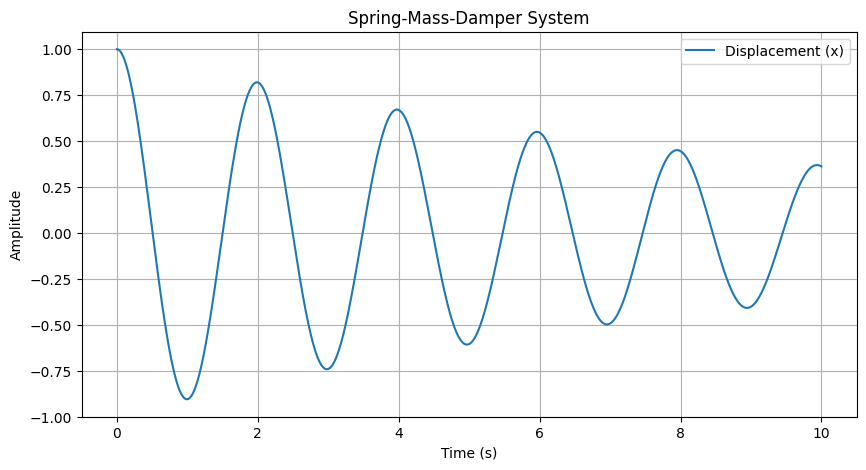

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define parameters
m = 1.0      # Mass (kg)
c = 0.2      # Damping coefficient (N·s/m)
k = 10      # Spring constant (N/m)
f = lambda t: 0  # External force, e.g., a sinusoidal force

# Define the system of equations
def spring_mass_damper(t, y):
    x, v = y  # y[0] is x (position), y[1] is v (velocity)
    dxdt = v
    dvdt = (f(t) - c * v - k * x) / m
    return [dxdt, dvdt]

# Initial conditions: x(0) = 0 (initial position), v(0) = 0 (initial velocity)
y0 = [1.0, 0.0]

# Time span for the simulation
t_span = (0, 50)         # From t = 0 to t = 10 seconds
t_eval = np.linspace(0, 10, 1000)  # Points at which to store the solution

# Solve the ODE
solution = solve_ivp(spring_mass_damper, t_span, y0, t_eval=t_eval)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(solution.t, solution.y[0], label='Displacement (x)')
#plt.plot(solution.t, solution.y[1], label='Velocity (v)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Spring-Mass-Damper System')
plt.legend()
plt.grid()
plt.show()


In the second method, we use MLP to encode the ODE in the loss function and optimise it for the solutions.

Epoch 0, Loss: 1.3566460609436035
Epoch 100, Loss: 0.9354860186576843
Epoch 200, Loss: 0.8716762065887451
Epoch 300, Loss: 0.8307605981826782
Epoch 400, Loss: 0.7973263263702393
Epoch 500, Loss: 0.713329553604126
Epoch 600, Loss: 0.5707389712333679
Epoch 700, Loss: 0.5524469017982483
Epoch 800, Loss: 0.555677592754364
Epoch 900, Loss: 0.5301928520202637
Epoch 1000, Loss: 0.526801347732544
Epoch 1100, Loss: 0.5216473340988159
Epoch 1200, Loss: 0.5219056606292725
Epoch 1300, Loss: 0.5143921375274658
Epoch 1400, Loss: 0.5090959072113037
Epoch 1500, Loss: 0.50609290599823
Epoch 1600, Loss: 0.5015973448753357
Epoch 1700, Loss: 0.4976159930229187
Epoch 1800, Loss: 0.4937998056411743
Epoch 1900, Loss: 0.4907253682613373
Epoch 2000, Loss: 0.48689842224121094
Epoch 2100, Loss: 0.4878062903881073
Epoch 2200, Loss: 0.48023566603660583
Epoch 2300, Loss: 0.47604191303253174
Epoch 2400, Loss: 0.4822797179222107
Epoch 2500, Loss: 0.46787029504776
Epoch 2600, Loss: 0.4626810848712921
Epoch 2700, Loss:

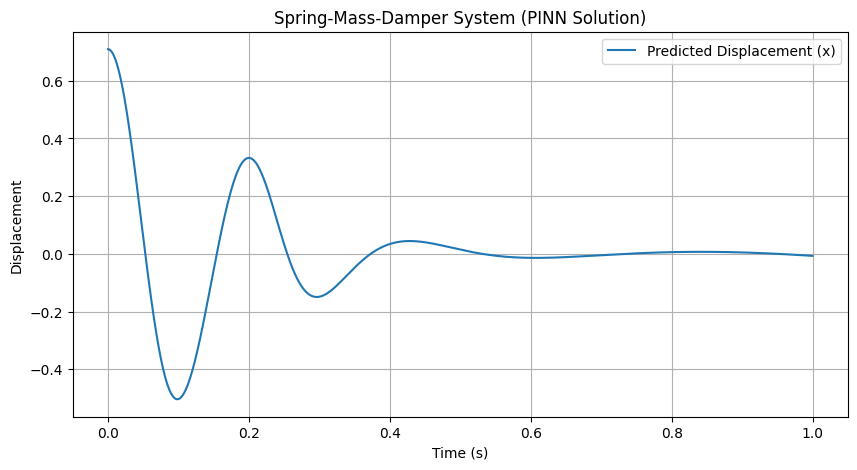

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define system parameters
m = 1.0  # Mass (kg)
c = 0.2  # Damping coefficient (N·s/m)
k = 10  # Spring constant (N/m)
f_ext = 0  # External force (constant force in this case)

# Neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t):
        return self.hidden(t)

# Define the differential equation loss
def loss_fn(model, t):
    # Ensure t requires gradients for computing derivatives
    t = t.clone().detach().requires_grad_(True)

    # Predict displacement
    x = model(t)

    # Compute first derivative (velocity)
    dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]

    # Compute second derivative (acceleration)
    d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]

    # Define the external force as a constant tensor
    f = f_ext * torch.ones_like(t)

    # Differential equation residual
    residual = m * d2x_dt2/100 + c * dx_dt/10 + k * x - f

    # Initial conditions (t=0)
    t0 = torch.tensor([[0.0]], requires_grad=True)
    x0 = model(t0)
    dx_dt0 = torch.autograd.grad(x0, t0, grad_outputs=torch.ones_like(x0), create_graph=True)[0]

    # Combine residual and initial conditions in the loss
    loss_residual = torch.mean(residual**2)
    loss_ic = (x0 - 1)**2 + (dx_dt0/10 - 0)**2  # initial conditions: x(0) = 0, dx/dt(0) = 0

    return loss_residual + loss_ic


# Training
def train_pinn(model, epochs=10000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    t_train = torch.linspace(0, 1, 1000).view(-1, 1)  # Training points (reshaped for input to NN)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, t_train)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    return t_train

# Instantiate and train the model
model = PINN()
t_train = train_pinn(model)

# Plot results
t_eval = torch.linspace(0, 1, 1000).view(-1, 1)
with torch.no_grad():
    x_pred = model(t_eval).numpy()

plt.figure(figsize=(10, 5))
plt.plot(t_eval.numpy(), x_pred, label="Predicted Displacement (x)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement")
plt.title("Spring-Mass-Damper System (PINN Solution)")
plt.legend()
plt.grid()
plt.show()


In the third method, we use the fourtier features to encode the ODE as the loss function. 10 frequencies are used, that is passed through the num_fourier_features object.

Epoch 0, Loss: 3.4730935096740723
Epoch 100, Loss: 0.21005457639694214
Epoch 200, Loss: 0.02729780040681362
Epoch 300, Loss: 0.0032312851399183273
Epoch 400, Loss: 0.000647371110972017
Epoch 500, Loss: 0.001391523634083569
Epoch 600, Loss: 0.0027262018993496895
Epoch 700, Loss: 0.00017051644681487232
Epoch 800, Loss: 0.003367944387719035
Epoch 900, Loss: 0.0006678113713860512
Epoch 1000, Loss: 0.0018646471435204148
Epoch 1100, Loss: 0.00011873326729983091
Epoch 1200, Loss: 9.203995432471856e-05
Epoch 1300, Loss: 0.0021908702328801155
Epoch 1400, Loss: 0.00010715511598391458
Epoch 1500, Loss: 0.004587625153362751
Epoch 1600, Loss: 4.2337935155956075e-05
Epoch 1700, Loss: 6.645331450272352e-05
Epoch 1800, Loss: 0.00041385384975001216
Epoch 1900, Loss: 3.308746454422362e-05
Epoch 2000, Loss: 4.7312765673268586e-05
Epoch 2100, Loss: 2.967318687296938e-05
Epoch 2200, Loss: 0.0007407335215248168
Epoch 2300, Loss: 4.499455098994076e-05
Epoch 2400, Loss: 0.00011295288277324289
Epoch 2500, Loss

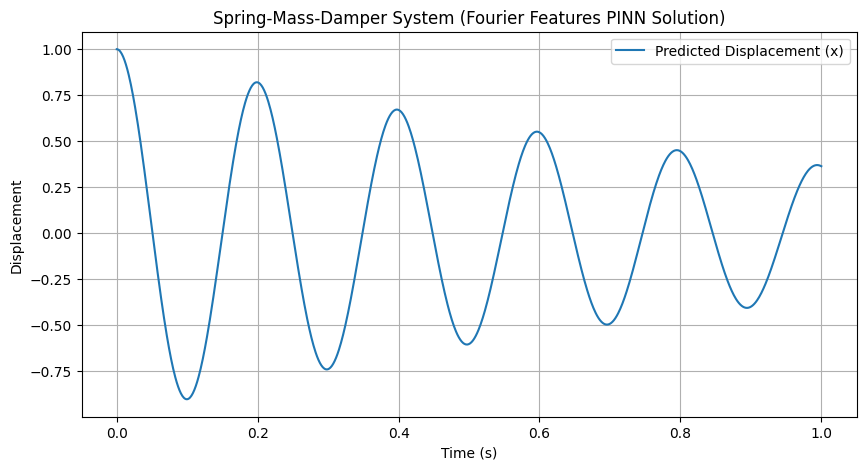

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define system parameters
m = 1.0  # Mass (kg)
c = 0.2  # Damping coefficient (N·s/m)
k = 10  # Spring constant (N/m)
f_ext = 0  # External force (constant force in this case)

# Fourier feature layer
class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, scale=10.0):
        super(FourierFeatures, self).__init__()
        self.B = nn.Parameter(scale * torch.randn(in_features, out_features), requires_grad=False)

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# Fourier Feature Neural Network model
class FourierPINN(nn.Module):
    def __init__(self, num_fourier_features=10):
        super(FourierPINN, self).__init__()
        self.fourier = FourierFeatures(1, num_fourier_features)
        self.hidden = nn.Sequential(
            nn.Linear(2 * num_fourier_features, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t):
        t_fourier = self.fourier(t)
        return self.hidden(t_fourier)

# Define the differential equation loss with initial conditions
def loss_fn(model, t):
    # Ensure t requires gradients for computing derivatives
    t = t.clone().detach().requires_grad_(True)

    # Predict displacement
    x = model(t)

    # Compute first derivative (velocity)
    dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]

    # Compute second derivative (acceleration)
    d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]

    # Define the external force as a constant tensor
    f = f_ext * torch.ones_like(t)

    # Differential equation residual
    residual = m * d2x_dt2/100 + c * dx_dt/10 + k * x - f

    # Initial conditions (t=0)
    t0 = torch.tensor([[0.0]], requires_grad=True)
    x0 = model(t0)
    dx_dt0 = torch.autograd.grad(x0, t0, grad_outputs=torch.ones_like(x0), create_graph=True)[0]

    # Combine residual and initial conditions in the loss
    loss_residual = torch.mean(residual**2)
    loss_ic = (x0 - 1)**2 + (dx_dt0/10 - 0)**2  # initial conditions: x(0) = 0, dx/dt(0) = 0

    return loss_residual + loss_ic

# Training
def train_pinn(model, epochs=7000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    t_train = torch.linspace(0, 1, 1000).view(-1, 1)  # Training points (reshaped for input to NN)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, t_train)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    return t_train

# Instantiate and train the model
model = FourierPINN()
t_train = train_pinn(model)

# Plot results
t_eval1 = torch.linspace(0, 1, 1000).view(-1, 1)
with torch.no_grad():
    x_pred1 = model(t_eval).numpy()

plt.figure(figsize=(10, 5))
plt.plot(t_eval1.numpy(), x_pred1, label="Predicted Displacement (x)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement")
plt.title("Spring-Mass-Damper System (Fourier Features PINN Solution)")
plt.legend()
plt.grid()
plt.show()


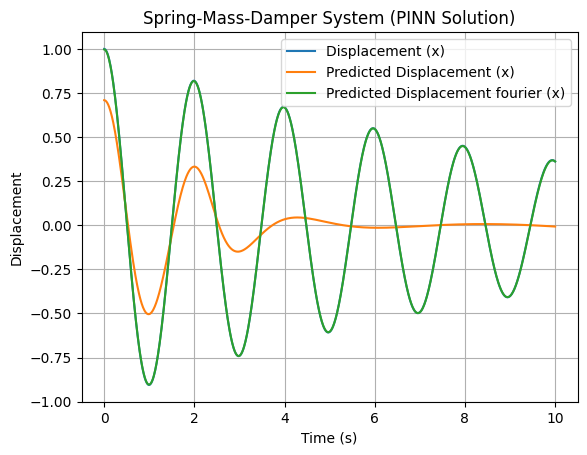

In [ ]:
plt.plot(solution.t, solution.y[0], label='Displacement (x)')
plt.plot(t_eval.numpy()*10, x_pred, label="Predicted Displacement (x)")
plt.plot(t_eval1.numpy()*10, x_pred1, label="Predicted Displacement fourier (x)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement")
plt.title("Spring-Mass-Damper System (PINN Solution)")
plt.legend()
plt.grid()
plt.show()